In [1]:
import itertools
import warnings

from statsmodels.tools.sm_exceptions import ValueWarning

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=ValueWarning)


from IPython.display import display
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
from math import sqrt
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

COLORS = px.colors.qualitative.Plotly


## data

In [2]:
DATA_PATH = Path("modelowanie-transferu-promieniowania")


### aerosol

,time,AOD340,AOD380,AOD440,AOD500,AOD675,AOD870,AOD1020
0,2004-05-05 16:10:08,0.204552,0.173638,0.136821,0.114673,0.080817,0.059331,0.047077
1,2005-04-23 05:36:51,0.117690,0.107533,0.089027,0.076464,0.052432,0.039169,0.031953
2,2005-04-23 05:48:57,0.112587,0.101896,0.083765,0.071127,0.047478,0.034127,0.027006
3,2005-04-23 06:02:50,0.111694,0.101301,0.083893,0.072157,0.049651,0.036983,0.030057
4,2005-04-23 06:19:01,0.103990,0.094051,0.078021,0.067010,0.045217,0.033175,0.026048
...,...,...,...,...,...,...,...,...
28588,2022-06-28 17:01:50,NaN,0.035146,0.032691,0.032105,0.022989,0.023950,0.008774
28589,2022-06-28 17:06:50,NaN,0.039124,0.036097,0.035180,0.025888,0.025719,0.010697
28590,2022-06-28 17:11:50,NaN,0.038626,0.036248,0.034992,0.027202,0.031553,NaN
28591,2022-06-28 17:16:50,NaN,0.049765,0.035607,0.035201,0.025688,0.025904,0.011405


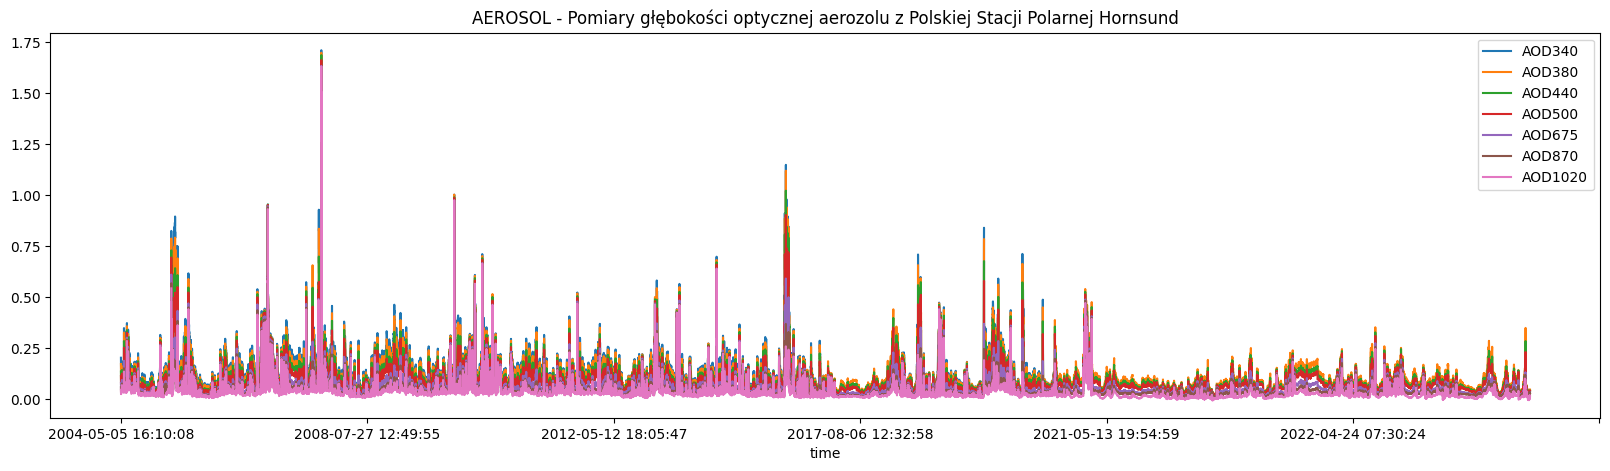

AEROSOL - Liczba braków danych w kolumnach
time: 0/28593 (0.00%)
AOD340: 11300/28593 (39.52%)
AOD380: 68/28593 (0.24%)
AOD440: 67/28593 (0.23%)
AOD500: 20/28593 (0.07%)
AOD675: 11/28593 (0.04%)
AOD870: 7/28593 (0.02%)
AOD1020: 123/28593 (0.43%)


In [3]:
aerosol = pd.read_csv(DATA_PATH / "aerosol.csv")
display(aerosol)

aerosol.plot(
    x="time",
    figsize=(20, 5),
    title="AEROSOL - Pomiary głębokości optycznej aerozolu z Polskiej Stacji Polarnej Hornsund",
)
plt.show()

print("AEROSOL - Liczba braków danych w kolumnach")
for col in aerosol.columns:
    print(
        f"{col}: {aerosol[col].isna().sum()}/{len(aerosol)} ({aerosol[col].isna().sum()/ len(aerosol):.2%})"
    )


### cloud

,time,cldHght,cldFrc
0,2017-07-11 18:19:56,1068.0,NaN
1,2017-07-11 18:20:26,497.0,NaN
2,2017-07-11 18:20:56,537.0,NaN
3,2017-07-11 18:21:26,23.0,NaN
4,2017-07-11 18:21:56,430.0,NaN
...,...,...,...
4796373,2022-06-30 23:57:50,71.0,8.0
4796374,2022-06-30 23:58:20,79.0,8.0
4796375,2022-06-30 23:58:50,71.0,8.0
4796376,2022-06-30 23:59:20,78.0,8.0


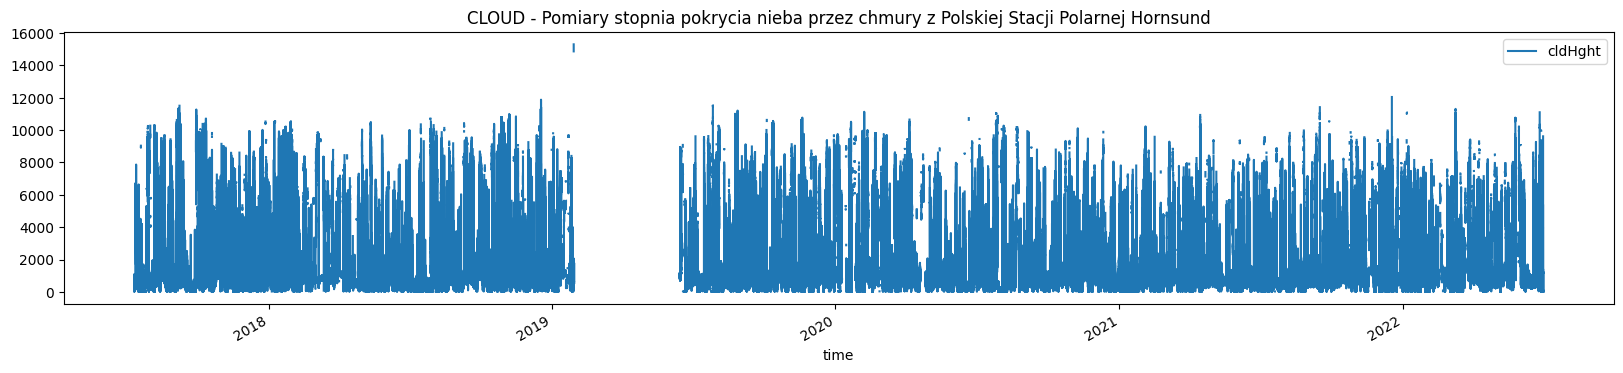

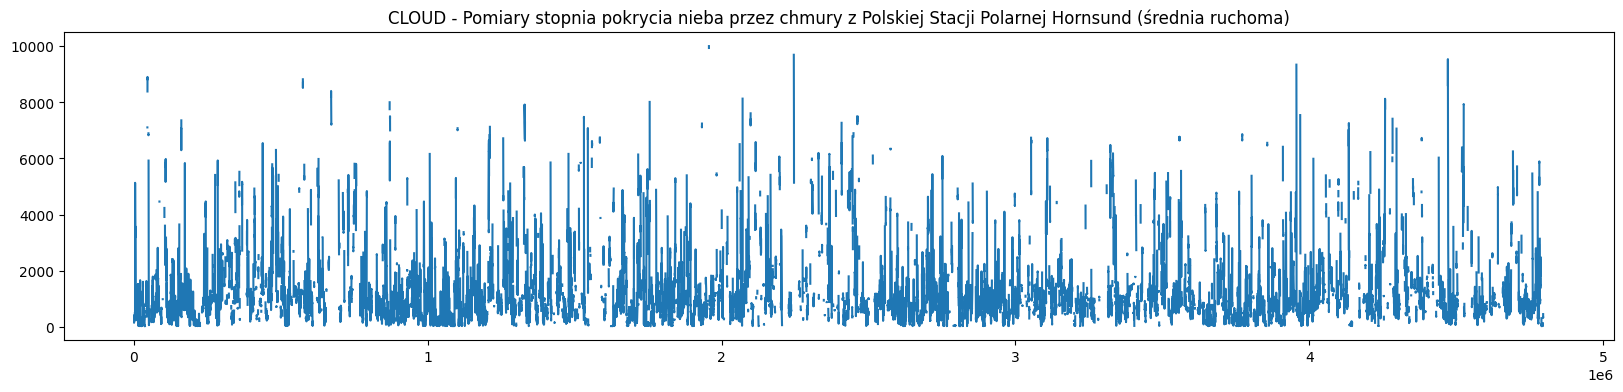

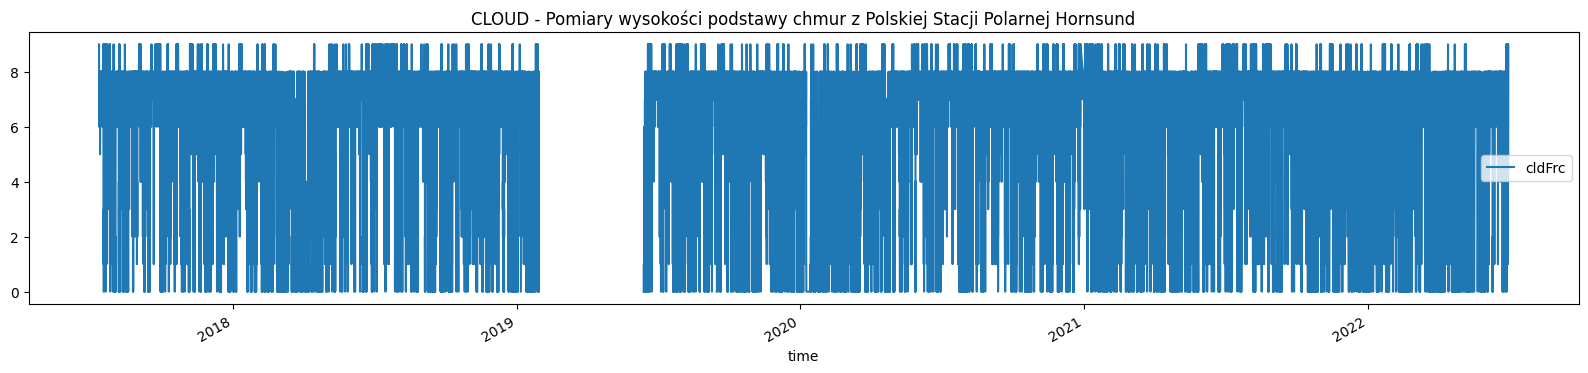

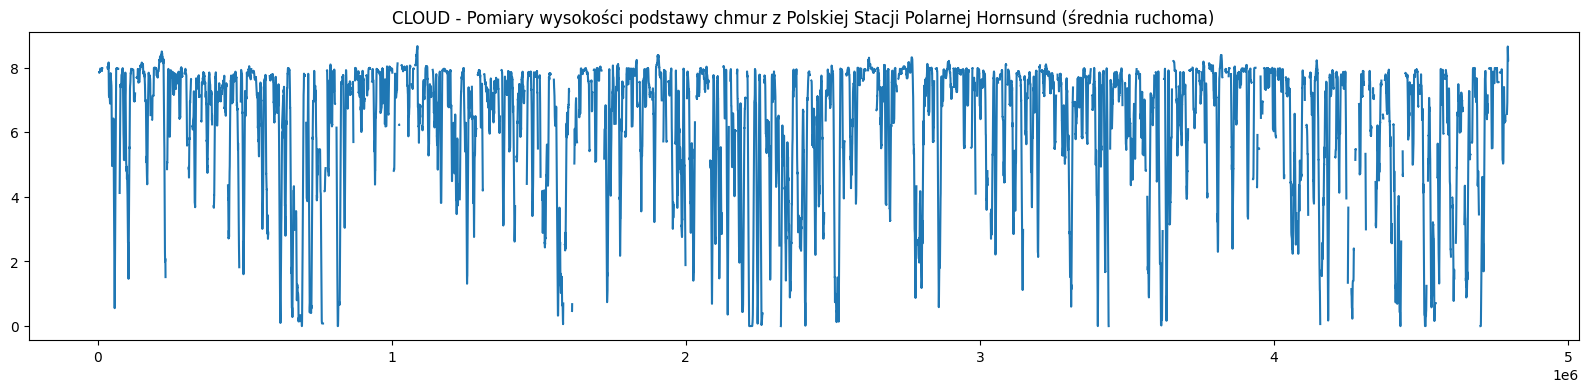

CLOUD - Liczba braków danych w kolumnach
time: 0/4796378 (0.00%)
cldHght: 1226578/4796378 (25.57%)
cldFrc: 15822/4796378 (0.33%)


In [4]:
# Pomiary stopnia pokrycia nieba przez chmury z Polskiej Stacji Polarnej Hornsund
cloud_h = pd.read_csv(DATA_PATH / "cloud_height.csv")
# Pomiary wysokości podstawy chmur z Polskiej Stacji Polarnej Hornsund
cloud_c = pd.read_csv(DATA_PATH / "cloud_cover.csv")


cloud = pd.merge(cloud_h, cloud_c, on="time", how="inner", copy=True)
cloud["time"] = pd.to_datetime(cloud["time"])
display(cloud)
cloud.plot(
    x="time",
    y="cldHght",
    figsize=(20, 4),
    title="CLOUD - Pomiary stopnia pokrycia nieba przez chmury z Polskiej Stacji Polarnej Hornsund",
)
plt.show()
fig, ax = plt.subplots(figsize=(20, 4))
plt.plot(cloud["cldHght"].rolling(300).mean())
plt.title(
    "CLOUD - Pomiary stopnia pokrycia nieba przez chmury z Polskiej Stacji Polarnej Hornsund (średnia ruchoma)"
)
plt.show()


cloud.plot(
    x="time",
    y="cldFrc",
    figsize=(20, 4),
    title="CLOUD - Pomiary wysokości podstawy chmur z Polskiej Stacji Polarnej Hornsund",
)
plt.show()
fig, ax = plt.subplots(figsize=(20, 4))
plt.plot(cloud["cldFrc"].rolling(5000).mean())
plt.title(
    "CLOUD - Pomiary wysokości podstawy chmur z Polskiej Stacji Polarnej Hornsund (średnia ruchoma)"
)
plt.show()


print("CLOUD - Liczba braków danych w kolumnach")
for col in cloud.columns:
    print(
        f"{col}: {cloud[col].isna().sum()}/{len(cloud)} ({cloud[col].isna().sum()/ len(cloud):.2%})"
    )


### train i test

,datetime,avgUV30min
0,2017-07-23 12:30:00,30.99099
1,2017-07-23 13:00:00,23.87401
2,2017-07-23 13:30:00,21.96042
3,2017-07-23 14:00:00,27.68454
4,2017-07-23 14:30:00,31.32608
...,...,...
85097,2022-06-30 21:30:00,9.25946
85098,2022-06-30 22:00:00,6.98760
85099,2022-06-30 22:30:00,5.65167
85100,2022-06-30 23:00:00,3.79267


TRAIN - Liczba braków danych w kolumnach
datetime: 0/85102 (0.00%)
avgUV30min: 51535/85102 (60.56%)


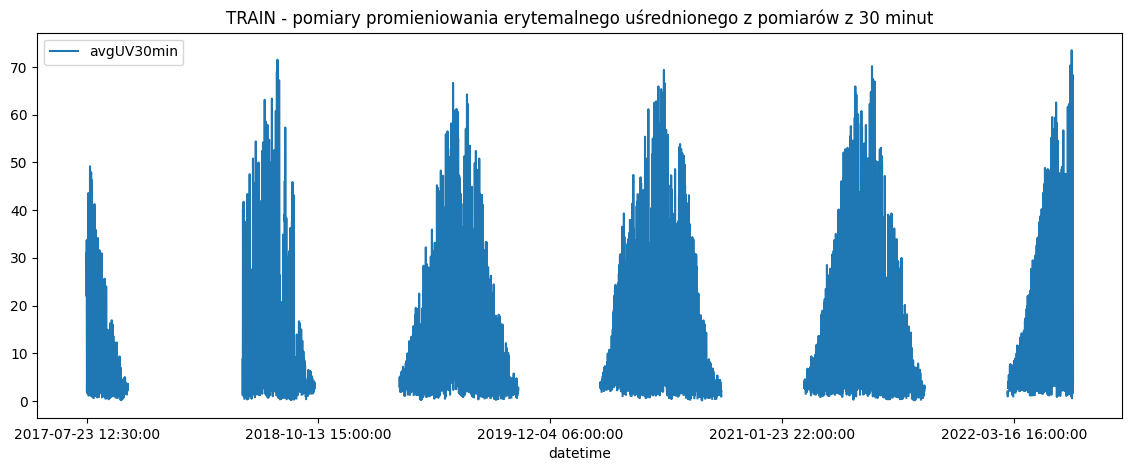

In [5]:
# Plik z danymi treningowymi zawierające pomiary promieniowania erytemalnego uśrednionego z pomiarów z 30 minut
train = pd.read_csv(DATA_PATH / "train.csv")
display(train)

train.plot(
    x="datetime",
    y="avgUV30min",
    figsize=(14, 5),
    title="TRAIN - pomiary promieniowania erytemalnego uśrednionego z pomiarów z 30 minut",
)


print("TRAIN - Liczba braków danych w kolumnach")
for col in train.columns:
    print(
        f"{col}: {train[col].isna().sum()}/{len(train)} ({train[col].isna().sum()/ len(train):.2%})"
    )

train["datetime"] = pd.to_datetime(train["datetime"])
train.set_index("datetime", inplace=True)
train = train.dropna()


In [6]:
MIN_DATE = "2019-01-01"


def prepare_splits(train_df):
    train_df = train_df.copy()
    train_df = train_df[train_df.index >= MIN_DATE]
    train_df = train_df.diff().dropna()

    train_split, val_split = train_df.iloc[:-240], train_df.iloc[-240:]
    train_y = train_split["avgUV30min"]
    val_y = val_split["avgUV30min"]

    return train_y, val_y


def prepare_test(train_df):
    train_df = train_df.copy()
    train_df = train_df[train_df.index >= MIN_DATE]
    train_df = train_df.diff().dropna()

    train_y = train_df["avgUV30min"]
    return train_y


train_y, val_y = prepare_splits(train)


# predicition

In [7]:
def plot_series(
    data_series_list: list,
    smooth: bool = False,
    smooth_window: int = 10,
    labels: list = None,
    forecast: pd.Series = None,
    test_confidence: pd.DataFrame = None,
):
    fig, ax = plt.subplots(1, figsize=(14, 3), tight_layout=True)

    for idx, data_series in enumerate(data_series_list):
        if smooth:
            data_series = data_series.rolling(window=smooth_window).mean()
        ax.plot(
            data_series,
            color=COLORS[idx],
            linewidth=0.5,
            label=labels[idx] if labels else None,
        )

        if test_confidence is not None and idx == len(data_series_list) - 1:
            ax.fill_between(
                forecast.index,
                test_confidence[0],
                test_confidence[1],
                color="grey",
                alpha=0.3,
            )

    ax.set_ylabel("avgUV30min")
    ax.set_xlabel("Time")

    if labels:
        ax.legend()
    plt.suptitle(f"UV Radiation through time", fontsize=16, y=1.02)
    plt.show()


In [8]:
DEFAULTS_PARAMS = dict(order=(0, 0, 0), seasonal_order=(1, 0, 1, 24))


def search_params(train_y, val_y, param_name, param_values):
    for value in param_values:
        kwargs = DEFAULTS_PARAMS | {param_name: value}
        print(kwargs)
        model = ARIMA(train_y, **kwargs)
        model = model.fit()

        forecast = model.forecast(steps=len(val_y))
        forecast.index = val_y.index

        train_y_real = train_y.cumsum()
        val_y_real = val_y.cumsum() + train_y_real.iloc[-1]
        forecast_real = forecast.cumsum() + train_y_real.iloc[-1]
        print((forecast_real < 0).sum())
        forecast_real = forecast_real.clip(lower=0)

        rms = sqrt(mean_squared_error(val_y_real, forecast_real))
        print("RMSE: ", rms)
        plot_series(
            [train_y_real[-500:], val_y_real, forecast_real],
            smooth=False,
            smooth_window=1,
            labels=["Train", "Val", "Forecast"],
            forecast=forecast.cumsum(),
        )


{'order': (0, 0, 0), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.357829643973089


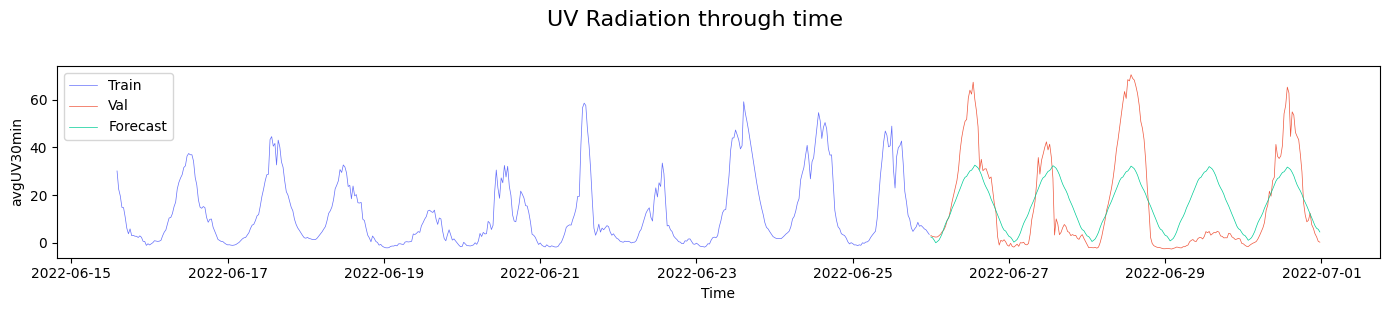

{'order': (0, 0, 1), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.50850799625927


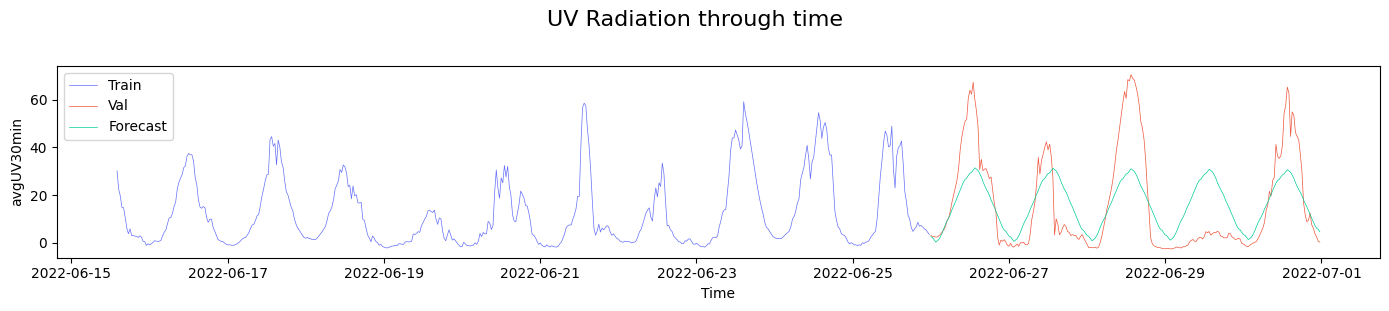

{'order': (0, 0, 2), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.58398559889203


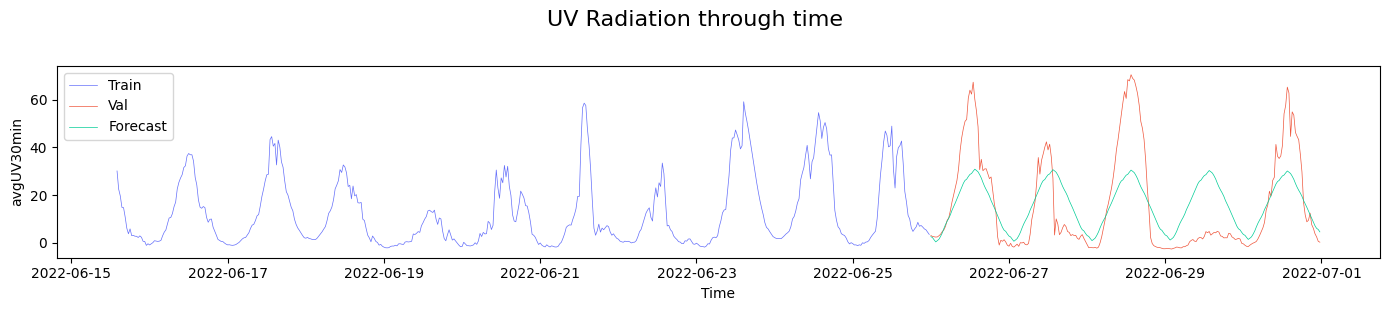

{'order': (1, 0, 0), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.624971796981578


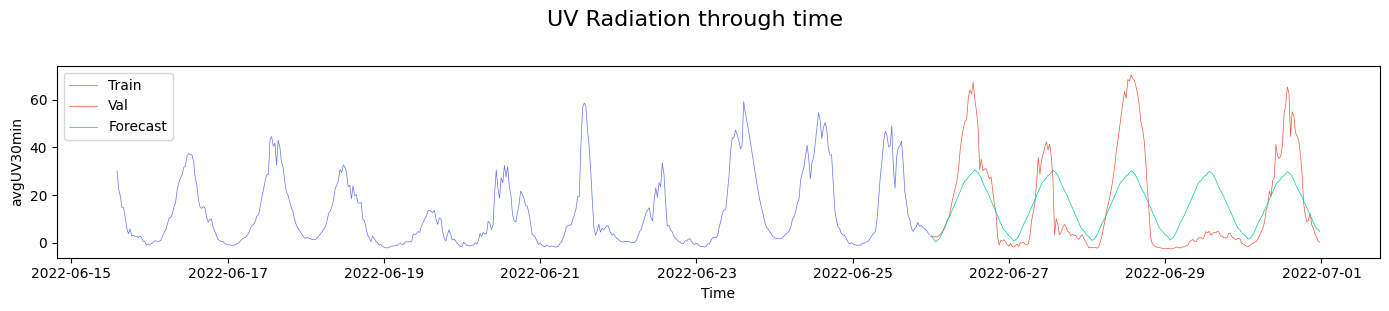

{'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.847843297542715


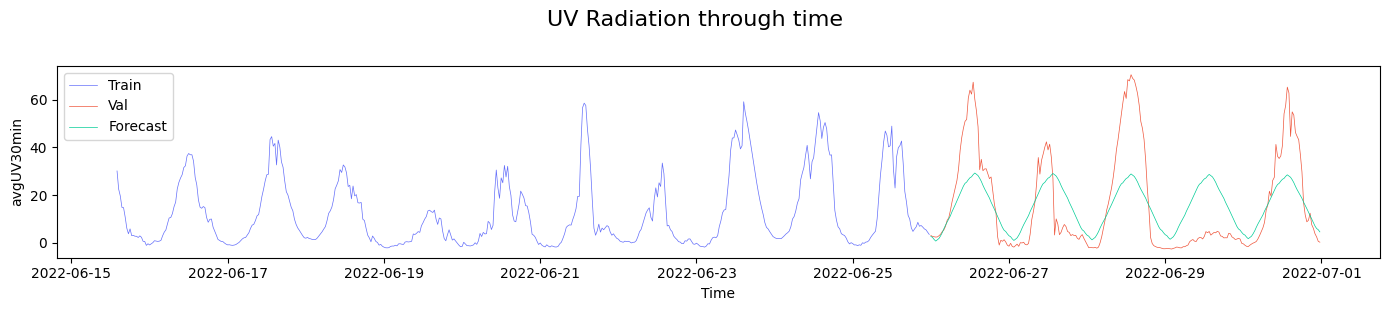

{'order': (1, 0, 2), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.839492776934842


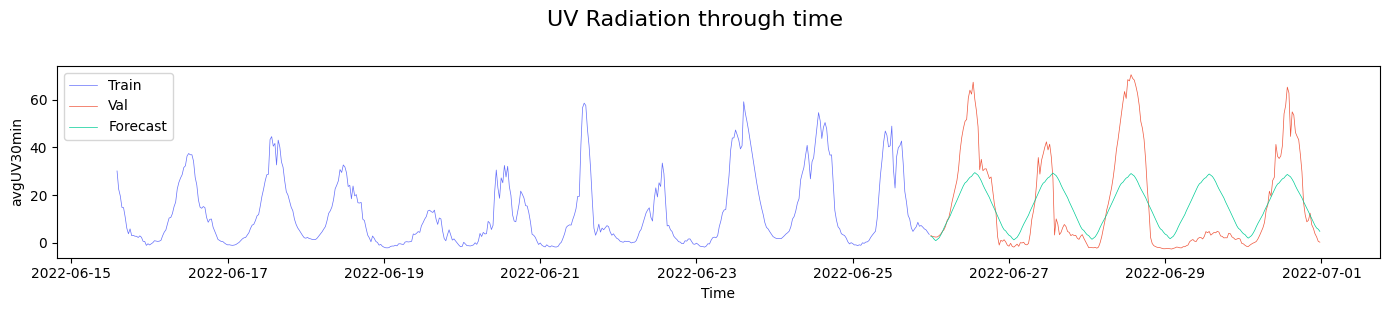

{'order': (2, 0, 0), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.7108840980851


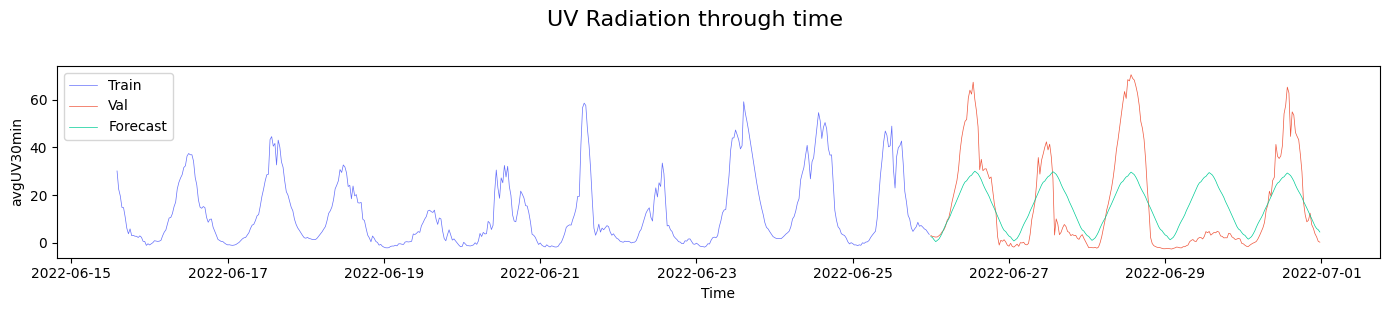

{'order': (2, 0, 1), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.840780289644231


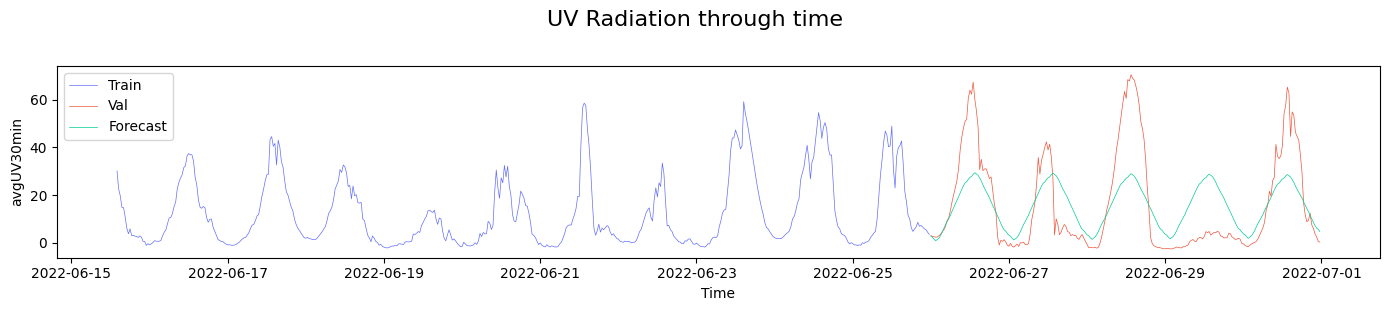

{'order': (2, 0, 2), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.849746051721667


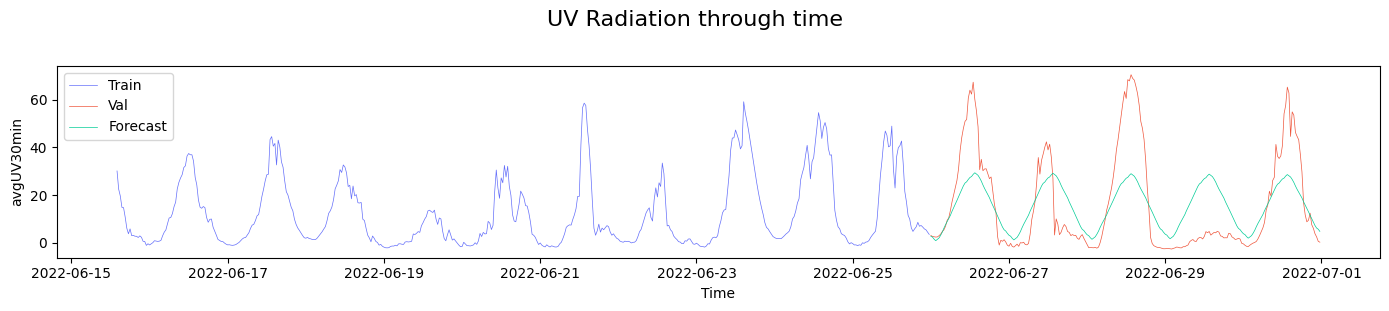

In [9]:
DEFAULTS_PARAMS = dict(order=(2, 0, 3), seasonal_order=(1, 0, 1, 24))

order_values = [o for o in itertools.product(range(3), repeat=3) if o[1] == 0]
search_params(train_y, val_y, param_name="order", param_values=order_values)


{'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 24)}
0
RMSE:  24.712343067235356


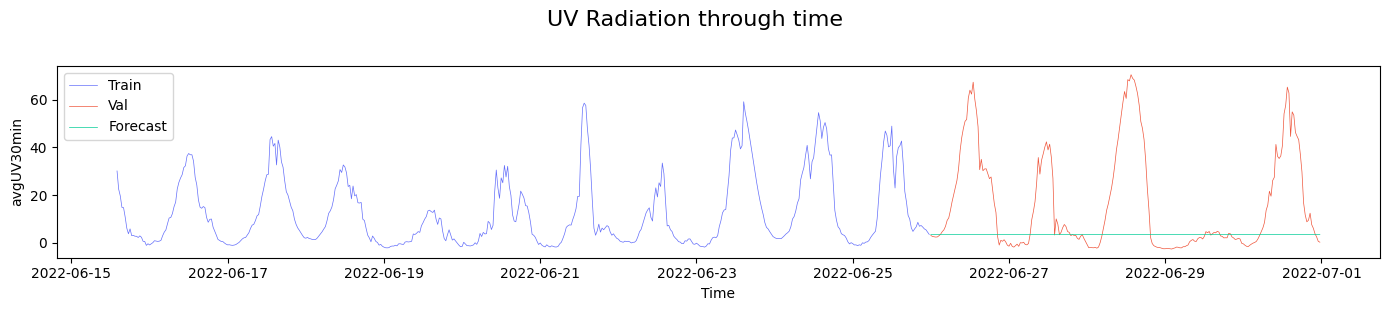

{'order': (0, 0, 0), 'seasonal_order': (0, 0, 1, 24)}
0
RMSE:  22.656627359252475


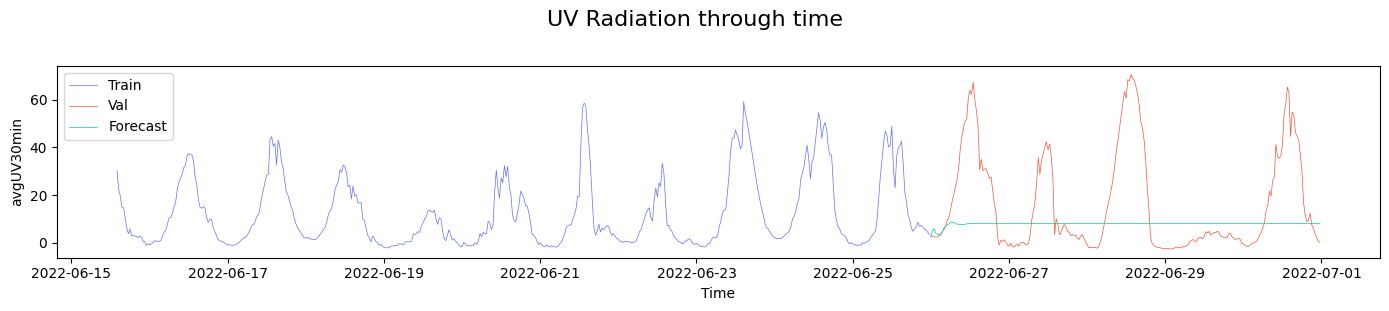

{'order': (0, 0, 0), 'seasonal_order': (0, 0, 2, 24)}
0
RMSE:  22.107633865070653


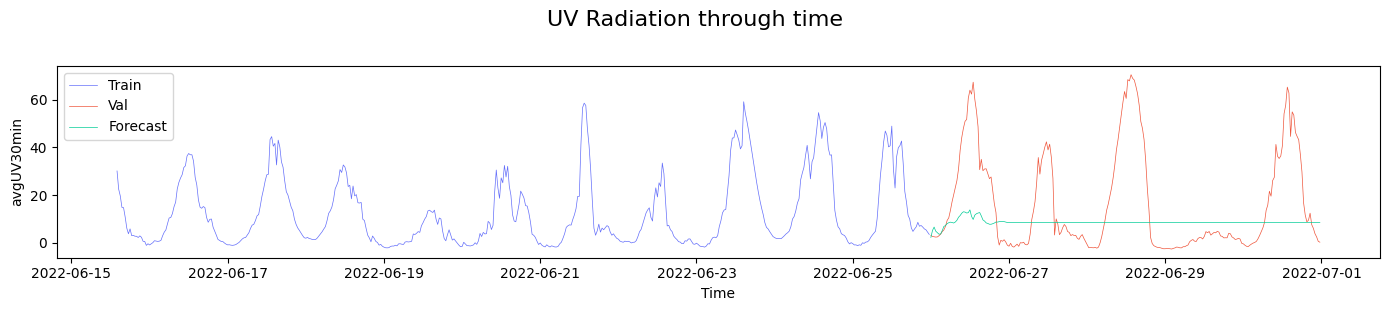

{'order': (0, 0, 0), 'seasonal_order': (1, 0, 0, 24)}
0
RMSE:  22.031786872451832


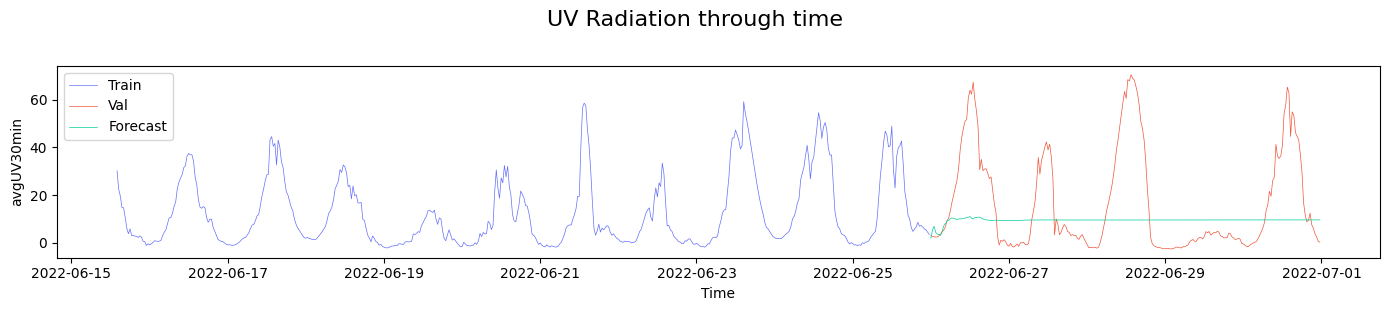

{'order': (0, 0, 0), 'seasonal_order': (1, 0, 1, 24)}
0
RMSE:  15.357829643973089


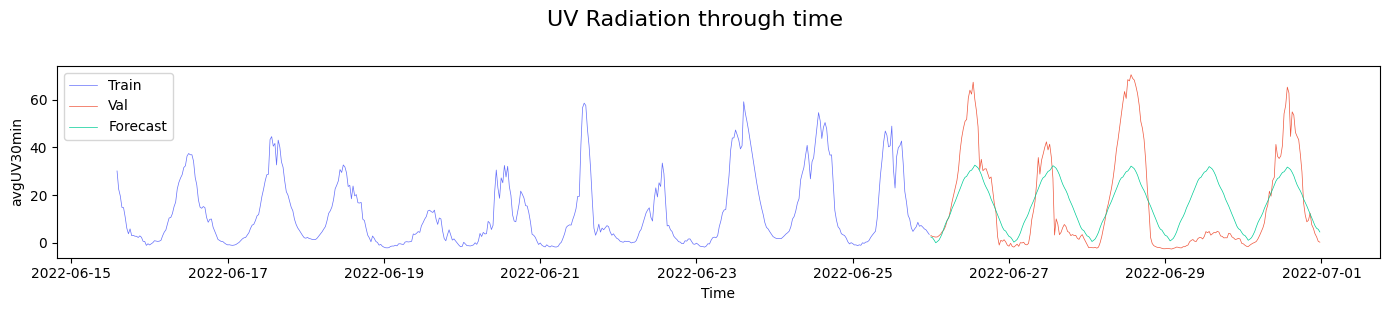

{'order': (0, 0, 0), 'seasonal_order': (1, 0, 2, 24)}
0
RMSE:  15.356311321894044


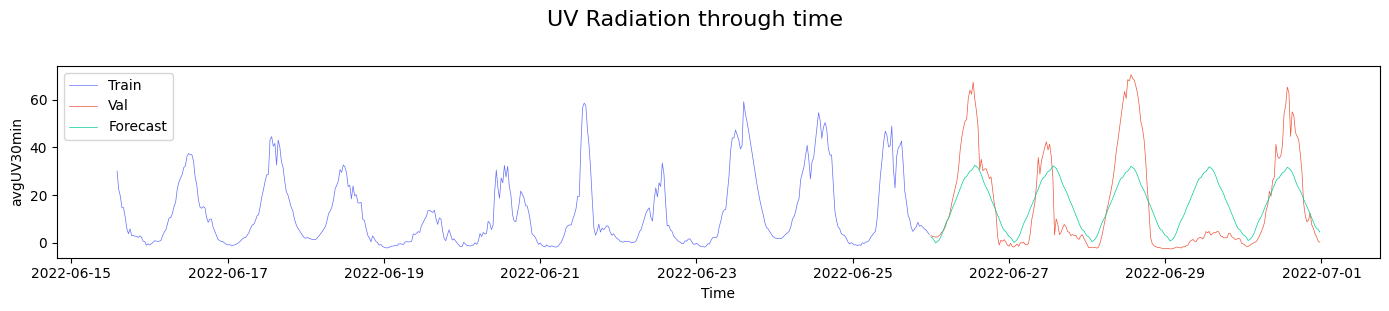

{'order': (0, 0, 0), 'seasonal_order': (2, 0, 0, 24)}
0
RMSE:  21.109044532897457


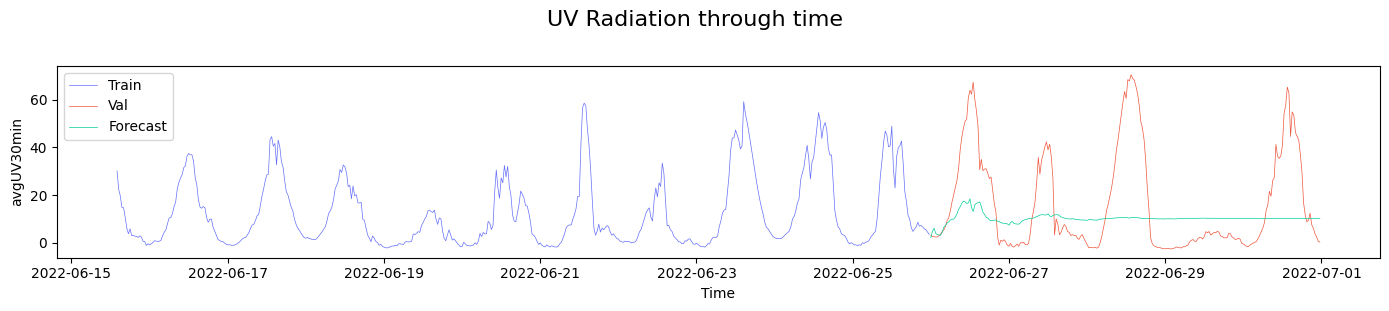

{'order': (0, 0, 0), 'seasonal_order': (2, 0, 1, 24)}
1
RMSE:  15.356318385764547


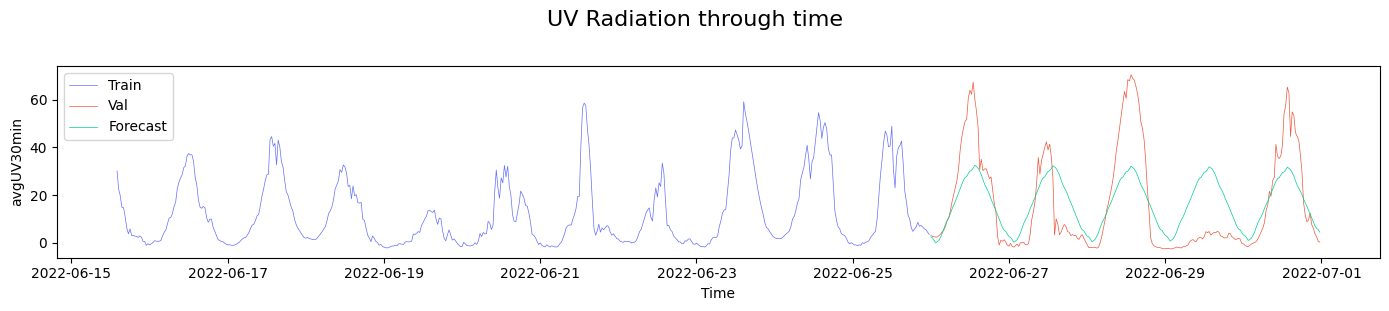

{'order': (0, 0, 0), 'seasonal_order': (2, 0, 2, 24)}
0
RMSE:  15.135580005852438


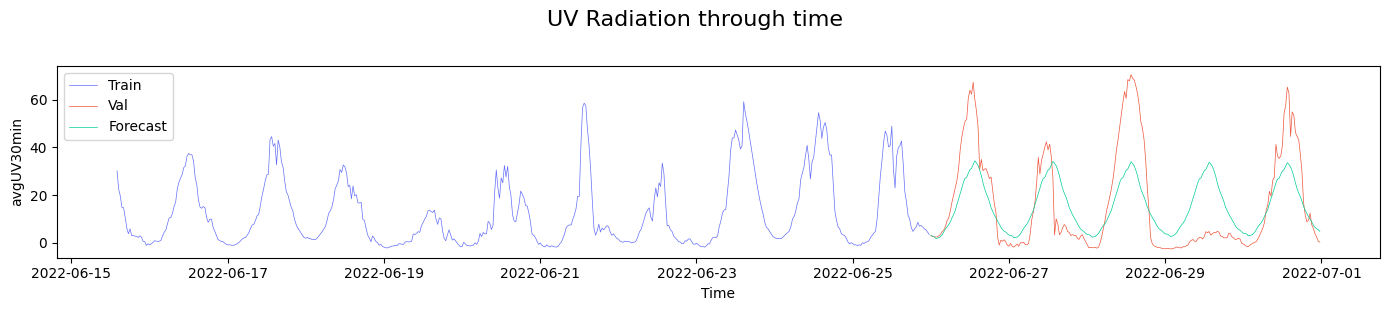

In [10]:
DEFAULTS_PARAMS = dict(order=(0, 0, 0), seasonal_order=(1, 0, 1, 24))

season_order_values = [
    (*o, 24) for o in itertools.product(range(3), repeat=3) if o[1] == 0
]
search_params(
    train_y, val_y, param_name="seasonal_order", param_values=season_order_values
)


## test

In [10]:
test = pd.read_csv(DATA_PATH / "test.csv")
test["datetime"] = pd.to_datetime(test["datetime"])

display(test)
test.set_index("datetime", inplace=True)


,datetime
0,2022-07-01 00:00:00
1,2022-07-01 00:30:00
2,2022-07-01 01:00:00
3,2022-07-01 01:30:00
4,2022-07-01 02:00:00
...,...
235,2022-07-05 21:30:00
236,2022-07-05 22:00:00
237,2022-07-05 22:30:00
238,2022-07-05 23:00:00


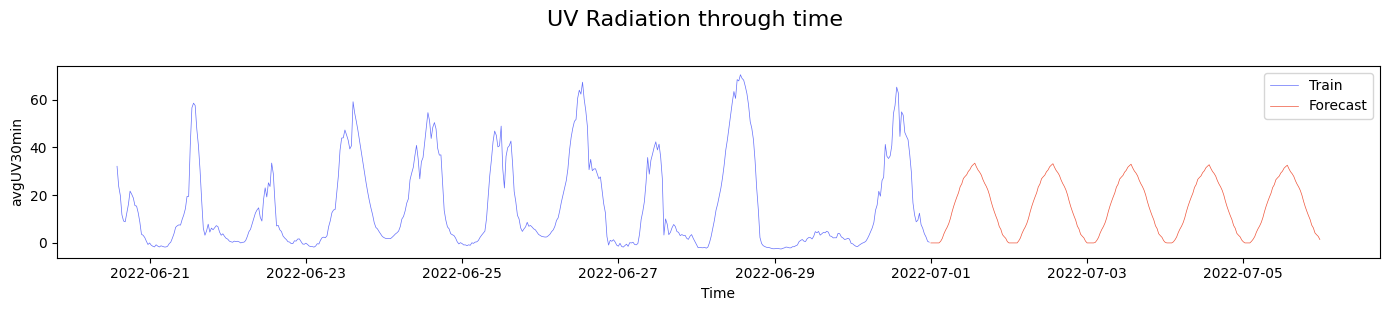

In [11]:
full_train_y = prepare_test(train)

model = ARIMA(full_train_y, order=(0, 0, 0), seasonal_order=(1, 0, 1, 24))
model = model.fit()

forecast = model.forecast(steps=len(test))
forecast.index = test.index

train_y_real = full_train_y.cumsum()
forecast_real = forecast.cumsum() + train_y_real.iloc[-1]
forecast_real = forecast_real.clip(lower=0)

plot_series(
    [train_y_real[-500:], forecast_real],
    smooth=False,
    smooth_window=1,
    labels=["Train", "Forecast"],
    forecast=forecast_real,
)


In [17]:
def create_submission(predictions):
    sample_submission = pd.read_csv(DATA_PATH / "sample_solution.csv")
    assert len(predictions) == len(sample_submission)
    sample_submission["avgUV30min"] = predictions.values
    print(sample_submission)
    sample_submission.to_csv("submission.csv", index=False)


In [18]:
create_submission(forecast_real)


                datetime  avgUV30min
0    2022-07-01 00:00:00    0.000000
1    2022-07-01 00:30:00    0.000000
2    2022-07-01 01:00:00    0.000000
3    2022-07-01 01:30:00    0.000000
4    2022-07-01 02:00:00    0.000000
..                   ...         ...
235  2022-07-05 21:30:00    6.294600
236  2022-07-05 22:00:00    4.191260
237  2022-07-05 22:30:00    3.415320
238  2022-07-05 23:00:00    2.741998
239  2022-07-05 23:30:00    1.428075

[240 rows x 2 columns]


In [ ]:
create_submission(forecast_real)
